In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np

In [3]:
%connect_info
%qtconsole

{
  "shell_port": 63145,
  "iopub_port": 63146,
  "stdin_port": 63147,
  "control_port": 63149,
  "hb_port": 63148,
  "ip": "127.0.0.1",
  "key": "40b2b55c-c9bc672933531184fa6c9446",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-9ad346e6-ac61-4a3a-8a3d-2b3c8a54cefd.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


Import data from csv fies

In [3]:
ppi_dat = pd.read_table('../data/yeast/4932.protein.links.full.v11.5.txt',  delimiter=' ')
ppi_dat = ppi_dat.loc[:, ['protein1', 'protein2', 'combined_score']].astype({'protein1': str, 'protein2': str, 'combined_score': 'float32'})
ppi_dat['protein1'] = ppi_dat.protein1.str.extract(r'[0-9]+\.(.+)')
ppi_dat['protein2'] = ppi_dat.protein2.str.extract(r'[0-9]+\.(.+)')
ppi_dat.head()

,protein1,protein2,combined_score
0,Q0010,YPL135W,347.0
1,Q0010,Q0017,945.0
2,Q0010,YOL103W,163.0
3,Q0010,YJR122W,528.0
4,Q0010,YGL043W,284.0


In [6]:
ppi_dat.to_csv('/Users/cgu3/Library/CloudStorage/OneDrive-InsideMDAnderson/PPI-project/pytorch_geometric/graphgym/data/yeast/raw/interaction/yeast_interaction.csv', index=False)

In [2]:
# ID ProteinProphet_Score P(K|S) mRNA(M) P(K|M) MSpresso_Score TP_or_TN_in_REFERENCEFILE
proteins = pd.read_table('../data/yeast/ypd_lcq_self_yp4gte2-or-notyp4_no-tm_score_id.txt', delimiter=' ', header=0,
                         names=['ID', 'ProteinProphet_Score', 'P(K|S)', 'mRNA(M)', 'P(K|M)', 'MSpresso_Score', 'TP_or_TN_in_REFERENCEFILE'])
proteins = proteins.loc[:, ['ID', 'ProteinProphet_Score', 'mRNA(M)', 'TP_or_TN_in_REFERENCEFILE']]
proteins['y'] = np.where(proteins.TP_or_TN_in_REFERENCEFILE == 'TP', 1, 0)
proteins.head()

,ID,ProteinProphet_Score,mRNA(M),TP_or_TN_in_REFERENCEFILE,y
0,YDR444W,0.49,0.15,TN,0
1,YHR213W,0.00,0.16,TN,0
2,YLR465C,0.00,0.16,TN,0
3,YDR543C,0.00,0.18,TN,0
4,YCR038C,0.00,0.19,TN,0


In [8]:
# protein_reference = pd.read_csv('../data/expressed-protein.csv')
# protein_reference.head()

In [9]:
# nextprot_dat = pd.read_csv('../data/nextprot-proteins.csv')
# nextprot_dat.head()

Transform protein accession to integer ID

## Proteins in PPI dataset but not in protein dataset
The protein dataset contain protein existence evidence information from an experiment (mostly  calculated protein identification features from MS spectrum)

The number of unique proteins in protein dataset and PPI dataset may not be the same.
We can either: 1. create those new protein entry in the protein dataset
or 2. only use PPI interaction information about proteins that exist in the protein dataset

STRING PPI database cover 99.47% of the proteins in the protein dataset of interest

In [107]:
# check PPI coverage for yeast
ppi_unique_proteins = np.unique(np.concatenate([ppi_dat['protein1'].to_numpy(), ppi_dat['protein2'].to_numpy()]))
coverage = np.mean(proteins.ID.isin(ppi_unique_proteins))
coverage

0.9947007481296758

In [10]:
# use approach 2 for simplicity
ppi_dat = ppi_dat[ppi_dat.protein1.isin(proteins.ID) & ppi_dat.protein2.isin(proteins.ID)]

# Create customized dataset

In [11]:
mapping = {index: i for i, index in enumerate(proteins.ID.unique())}

In [12]:
import torch
node_attr = proteins.loc[:, ['ProteinProphet_Score', 'mRNA(M)']]
node_attr
# node_attr.loc[:, 'protein_score'] = np.log10(node_attr.protein_score + 1)

,ProteinProphet_Score,mRNA(M)
0,0.49,0.15
1,0.00,0.16
2,0.00,0.16
3,0.00,0.18
4,0.00,0.19
...,...,...
3203,1.00,122.05
3204,0.00,125.56
3205,1.00,138.72
3206,1.00,153.36


In [13]:
# need to define some helper encoder and transformer class

class LogTransformation(object):
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(np.log10(df.values+ 1)).view(-1, 1).to(self.dtype)

In [14]:
# log_transformer = LogTransformation(dtype=torch.float)
# log_protein_score = log_transformer(node_attr.protein_score)

# to-do: need to standardized features
x = torch.from_numpy(node_attr.to_numpy(dtype=float)).to(dtype=torch.float)
# label variable need to be a (N, ) tensor
expressed = torch.tensor(proteins.y.values).view(-1).to(dtype=torch.long)
# x = torch.cat([log_protein_score], dim=-1)
# also need train_masking, test_masking

Create train, val, test masking variable tensor

In [15]:
import torch_geometric.transforms as T
split_transformer = T.RandomNodeSplit(split='train_rest', num_splits=1, num_val=0.2, num_test=0.2)

In [16]:
src = [mapping[index] for index in ppi_dat.protein1]
dst = [mapping[index] for index in ppi_dat.protein2]
edge_index = torch.tensor([src, dst])
edge_index_reverse = torch.tensor([dst, src])
# combined edge_index and edge_reverse_index to create undirected graph
edge_index = torch.cat([edge_index, edge_index_reverse], dim=-1)

In [17]:
edge_attr = torch.tensor(ppi_dat.combined_score.values.repeat(2)).view(-1, 1)

In [18]:
from  torch_geometric.data import Data

In [19]:
# create graph dataset with node features, edge index, and edge attributes
# the ground-truth label need to be fed as an additional variable to use RandomNodeSplit transformer
dataset = Data(x=x, edge_index=edge_index, split=1, edge_attr=edge_attr, y=expressed)
dataset.x

tensor([[4.9000e-01, 1.5000e-01],
        [0.0000e+00, 1.6000e-01],
        [0.0000e+00, 1.6000e-01],
        ...,
        [1.0000e+00, 1.3872e+02],
        [1.0000e+00, 1.5336e+02],
        [1.0000e+00, 2.2655e+02]])

Feature normalization

In [20]:
from torch_geometric.transforms import NormalizeFeatures
feature_normalizer = NormalizeFeatures(['x'])
dataset = feature_normalizer(dataset)

In [21]:
dataset = split_transformer(dataset)
dataset
dataset.x

Data(x=[3208, 2], edge_index=[2, 1587876], edge_attr=[1587876, 1], y=[3208], split=1, train_mask=[3208], val_mask=[3208], test_mask=[3208])

tensor([[0.4900, 0.1500],
        [0.0000, 0.1600],
        [0.0000, 0.1600],
        ...,
        [0.0072, 0.9928],
        [0.0065, 0.9935],
        [0.0044, 0.9956]])

In [22]:
print(f'Number of nodes: {dataset.num_nodes}')
print(f'Number of node features: {dataset.num_node_features}')
print(f'Number of edges: {dataset.num_edges}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
print(f'Number of training nodes: {dataset.train_mask.sum()}')
print(f'Training node label rate: {int(dataset.train_mask.sum()) / dataset.num_nodes:.2f}')
print(f'Validation node label rate: {int(dataset.val_mask.sum()) / dataset.num_nodes:.2f}')
print(f'Test node label rate: {int(dataset.test_mask.sum()) / dataset.num_nodes:.2f}')
print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
print(f'Has self-loops: {dataset.has_self_loops()}')
print(f'Is undirected: {dataset.is_undirected()}')

Number of nodes: 3208
Number of node features: 2
Number of edges: 1587876
Number of edge features: 1
Average node degree: 494.97
Number of training nodes: 1924
Training node label rate: 0.60
Validation node label rate: 0.20
Test node label rate: 0.20
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [23]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(num_features=12, hidden_channels=16, num_classes=2)
print(model)

MLP(
  (lin1): Linear(in_features=12, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [24]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(num_features=dataset.num_features, hidden_channels=16, num_classes=2)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(dataset.x)  # Perform a single forward pass.
      loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def val():
      model.eval()
      out = model(dataset.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[dataset.val_mask] == dataset.y[dataset.val_mask]  # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(dataset.val_mask.sum())  # Derive ratio of correct predictions.
      return val_acc


for epoch in range(1, 201):
    loss = train()
    val_acc = val()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, val: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.7020, val: 0.5623
Epoch: 002, Loss: 0.6975, val: 0.5623
Epoch: 003, Loss: 0.6920, val: 0.5639
Epoch: 004, Loss: 0.6891, val: 0.5530
Epoch: 005, Loss: 0.6892, val: 0.5530
Epoch: 006, Loss: 0.6882, val: 0.5607
Epoch: 007, Loss: 0.6841, val: 0.5561
Epoch: 008, Loss: 0.6885, val: 0.5592
Epoch: 009, Loss: 0.6828, val: 0.5607
Epoch: 010, Loss: 0.6822, val: 0.5670
Epoch: 011, Loss: 0.6805, val: 0.5670
Epoch: 012, Loss: 0.6789, val: 0.5717
Epoch: 013, Loss: 0.6768, val: 0.5717
Epoch: 014, Loss: 0.6729, val: 0.5717
Epoch: 015, Loss: 0.6712, val: 0.5717
Epoch: 016, Loss: 0.6678, val: 0.5717
Epoch: 017, Loss: 0.6623, val: 0.5717
Epoch: 018, Loss: 0.6684, val: 0.5717
Epoch: 019, Loss: 0.6638, val: 0.5919
Epoch: 020, Loss: 0.6614, val: 0.6028
Epoch: 021, Loss: 0.6629, val: 0.6012
Epoch: 022, Loss: 0.6594, val: 0.6168
Epoch: 023, Loss: 0.6559, val: 0.6231
Epoch: 024, Loss: 0.6605, val: 0.6262
Epoch: 025, Loss: 0.6548, val: 0.6293
Epoch: 026, Loss: 0.6478, val: 0.6355
Epoch: 027, 

In [25]:


def test():
      model.eval()
      out = model(dataset.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6963


In [26]:
from torch_geometric.nn import GCNConv
import torch_geometric.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        # self.batch_norm1 = nn.BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        # self.batch_norm2 = nn.BatchNorm(hidden_channels)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        # use batchnorm instead of dropout
        x = F.dropout(x, p=0.5, training=self.training)
        # x = self.batch_norm1(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(num_node_features=dataset.num_node_features, hidden_channels=16, num_classes=2)
print(model)

GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 2)
)


In [27]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# uncomment for first time run
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=30, alpha=0.5, c=color, cmap="Set2")
    plt.show()

1.12.1


GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 2)
)

/Users/cgu3/opt/anaconda3/envs/graph-neural-network/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/cgu3/opt/anaconda3/envs/graph-neural-network/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


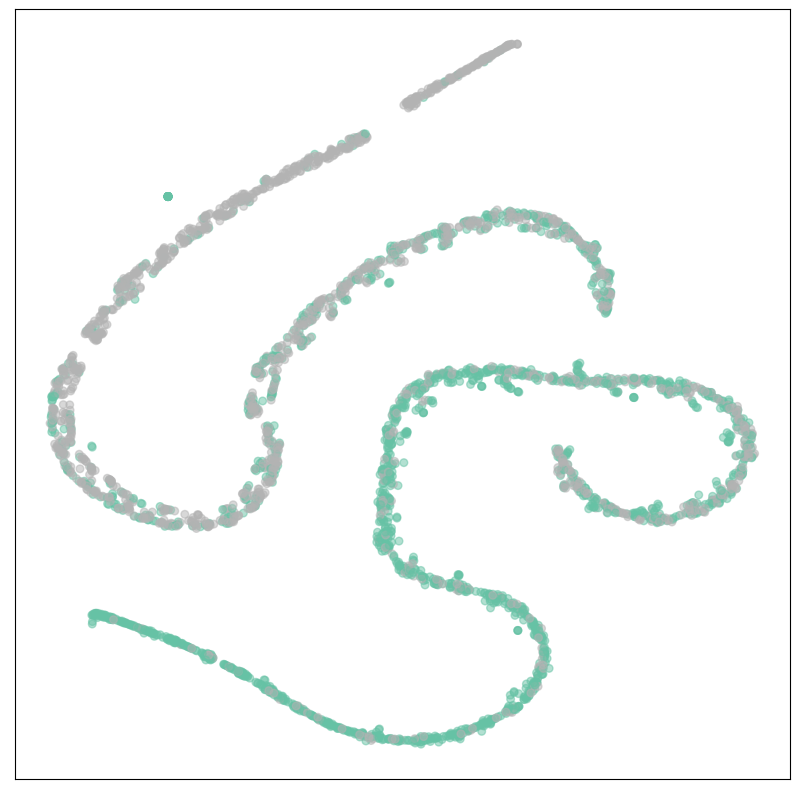

In [28]:
model = GCN(num_node_features=dataset.num_node_features, hidden_channels=16, num_classes=2)
model.eval()

out = model(dataset.x, dataset.edge_index)
visualize(out, color=dataset.y)

In [75]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(num_node_features=dataset.num_node_features, hidden_channels=16, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(dataset.x, dataset.edge_index)  # Perform a single forward pass.
      train_loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])  # Compute the loss solely based on the training nodes.
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      train_correct = pred[dataset.train_mask] == dataset.y[dataset.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(dataset.train_mask.sum())
      train_loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return float(train_loss.detach()), train_acc


def val():
      model.eval()
      out = model(dataset.x, dataset.edge_index)
      val_loss = criterion(out[dataset.val_mask], dataset.y[dataset.val_mask])
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[dataset.val_mask] == dataset.y[dataset.val_mask] # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(dataset.val_mask.sum())  # Derive ratio of correct predictions.
      return float(val_loss.detach()), val_acc

def test():
      model.eval()
      out = model(dataset.x, dataset.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

train_loss_history = []
train_acc_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 101):
    train_loss, train_acc = train()
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss, val_acc = val()
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f} Train acc: {train_acc:.4f} '
          f'Validation loss: {val_loss: .4f}, Validation acc: {val_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train loss: 0.6877 Train acc: 0.4605 Validation loss:  0.6902, Validation acc: 0.4299
Epoch: 002, Train loss: 0.6839 Train acc: 0.4657 Validation loss:  0.6877, Validation acc: 0.4424
Epoch: 003, Train loss: 0.6814 Train acc: 0.4745 Validation loss:  0.6851, Validation acc: 0.4502
Epoch: 004, Train loss: 0.6795 Train acc: 0.4875 Validation loss:  0.6827, Validation acc: 0.4720
Epoch: 005, Train loss: 0.6774 Train acc: 0.5099 Validation loss:  0.6802, Validation acc: 0.4969
Epoch: 006, Train loss: 0.6752 Train acc: 0.5390 Validation loss:  0.6779, Validation acc: 0.5249
Epoch: 007, Train loss: 0.6724 Train acc: 0.5650 Validation loss:  0.6755, Validation acc: 0.5452
Epoch: 008, Train loss: 0.6696 Train acc: 0.6071 Validation loss:  0.6732, Validation acc: 0.5732
Epoch: 009, Train loss: 0.6686 Train acc: 0.6247 Validation loss:  0.6711, Validation acc: 0.5966
Epoch: 010, Train loss: 0.6666 Train acc: 0.6190 Validation loss:  0.6689, Validation acc: 0.6090
Epoch: 011, Train lo

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

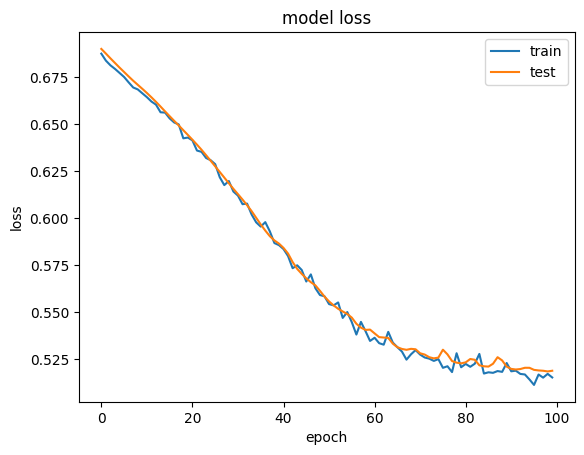

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'acc')

Text(0.5, 0, 'epoch')

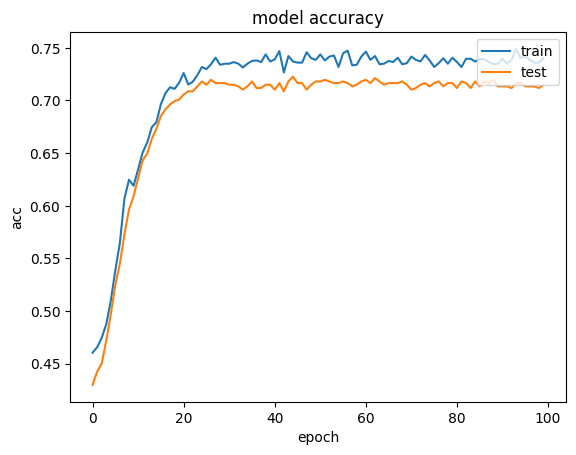

In [108]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [1]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

NameError: name 'test' is not defined

GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 2)
)

/Users/cgu3/opt/anaconda3/envs/graph-neural-network/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/cgu3/opt/anaconda3/envs/graph-neural-network/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


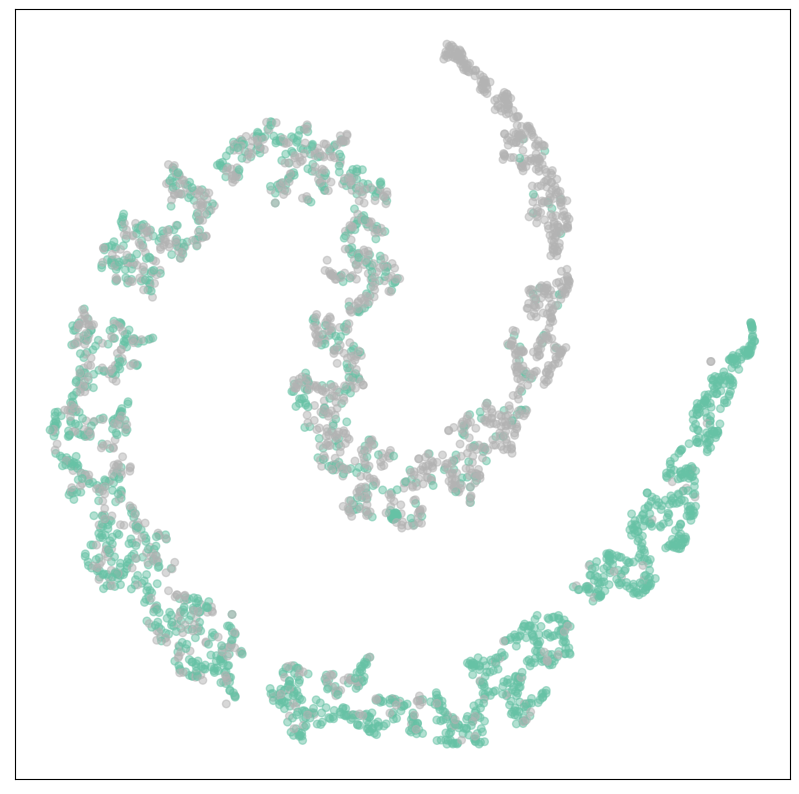

In [31]:
model.eval()

out = model(dataset.x, dataset.edge_index)
visualize(out, color=dataset.y)

In [32]:
# when dataset contain two graph
# to-do create dataset class


# need good standardization to generalize to model to different spices and experiment conditions
# semi-supervise
# transfer learning


# the performance is not good
# need to include more nodes features: protein characteristics, ...
# more ideal not use calculated protein score, instead use variables used to calculate protein score directly



# GPU resource